In [1]:
import os
import io

import detectron2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import some common libraries
import numpy as np
import cv2
import torch

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# Load VG Classes
data_path = 'data/genome/1600-400-20'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())
        
vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())


MetadataCatalog.get("vg").thing_classes = vg_classes
MetadataCatalog.get("vg").attr_classes = vg_attrs

In [3]:
cfg = get_cfg()
cfg.merge_from_file("../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
# VG Weight
cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl"
predictor = DefaultPredictor(cfg)

Config '../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401



In [4]:
NUM_OBJECTS = 20

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image

def doit(raw_image):
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
        print("Original image size: ", (raw_height, raw_width))
        
        # Preprocessing
        image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
        print("Transformed image size: ", image.shape[:2])
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)
        
        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)
        
        # Generate proposals with RPN
        proposals, _ = predictor.model.proposal_generator(images, features, None)
        proposal = proposals[0]
        print('Proposal Boxes size:', proposal.proposal_boxes.tensor.shape)
        
        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [x.proposal_boxes for x in proposals]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
        print('Pooled features size:', feature_pooled.shape)
        
        # Predict classes and boxes for each proposal.
        pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        outputs = FastRCNNOutputs(
            predictor.model.roi_heads.box2box_transform,
            pred_class_logits,
            pred_proposal_deltas,
            proposals,
            predictor.model.roi_heads.smooth_l1_beta,
        )
        probs = outputs.predict_probs()[0]
        boxes = outputs.predict_boxes()[0]
        
        attr_prob = pred_attr_logits[..., :-1].softmax(-1)
        max_attr_prob, max_attr_label = attr_prob.max(-1)
        
        # Note: BUTD uses raw RoI predictions,
        #       we use the predicted boxes instead.
        # boxes = proposal_boxes[0].tensor    
        
        # NMS
        for nms_thresh in np.arange(0.5, 0.6, 0.4):
            instances, ids = fast_rcnn_inference_single_image(
                boxes, probs, image.shape[1:], 
                score_thresh=0.2, nms_thresh=nms_thresh, topk_per_image=NUM_OBJECTS
            )
            if len(ids) == NUM_OBJECTS:
                break
                
        instances = detector_postprocess(instances, raw_height, raw_width)
        roi_features = feature_pooled[ids].detach()
        max_attr_prob = max_attr_prob[ids].detach()
        max_attr_label = max_attr_label[ids].detach()
        instances.attr_scores = max_attr_prob
        instances.attr_classes = max_attr_label
        
        print(instances)
        
        return instances, roi_features
    


# print(instances.pred_boxes)
# print(instances.scores)
# print(instances.pred_classes)
# print(instances.attr_classes)
# print(instances.attr_scores)


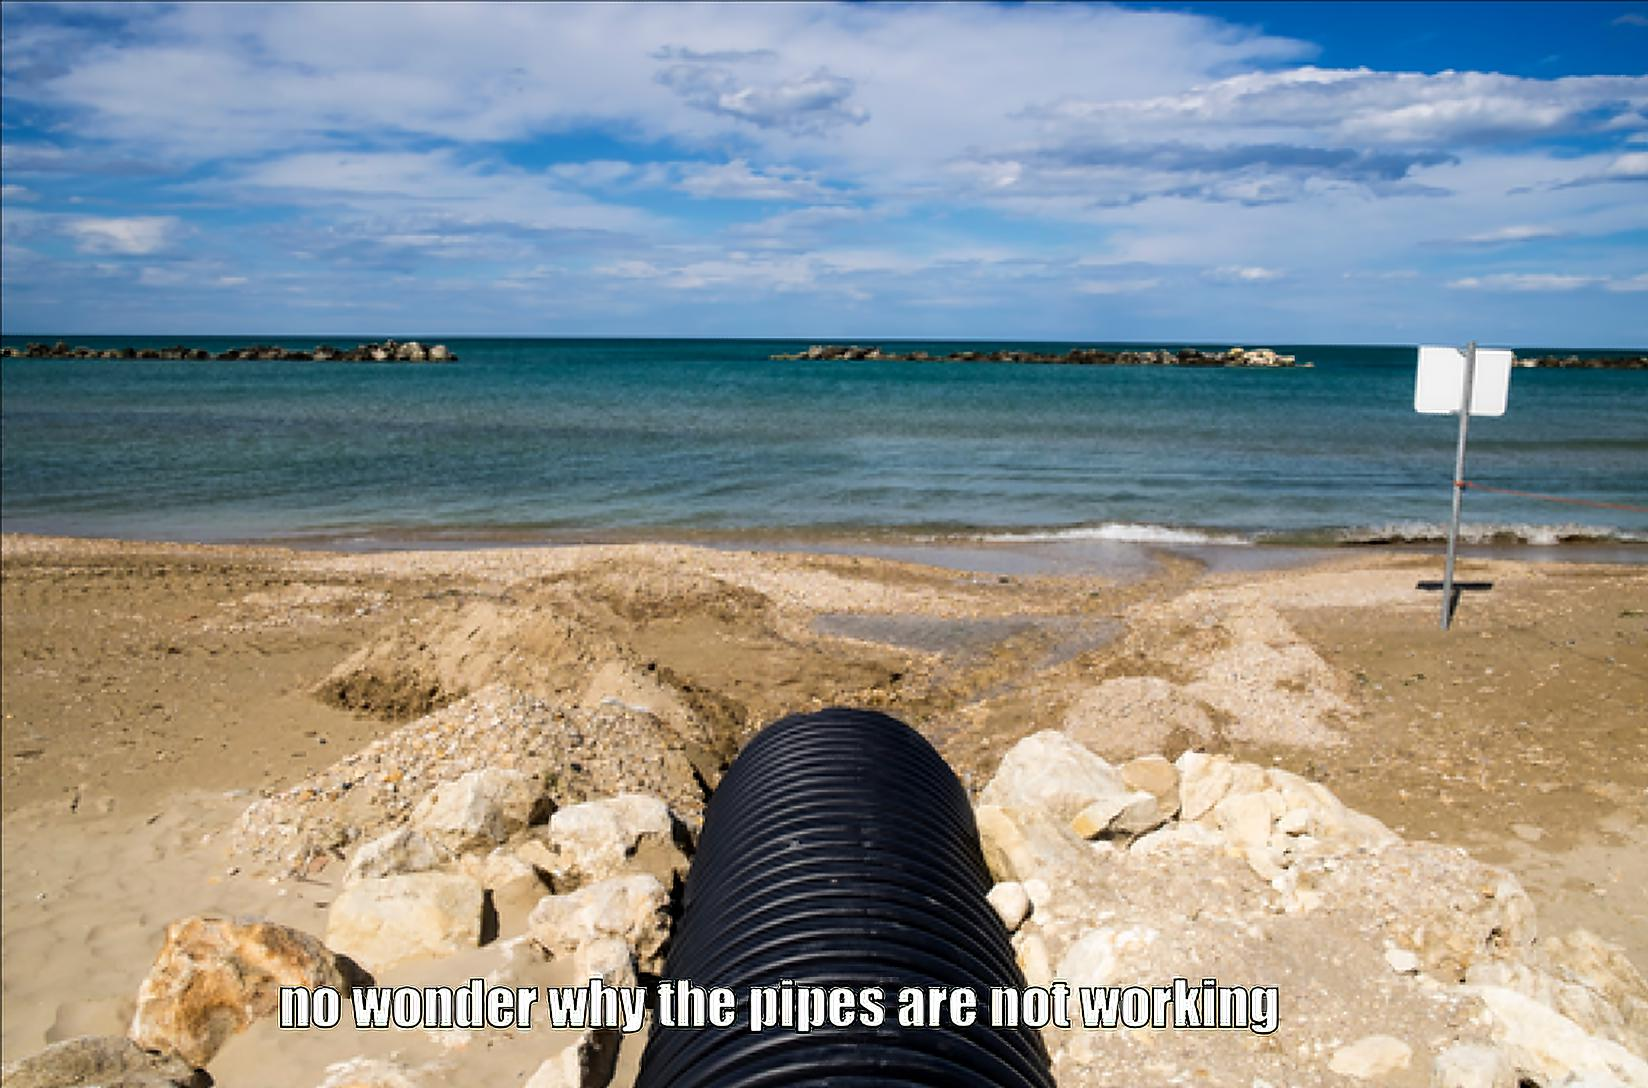

In [5]:
hateful_meme = "/home/ron/Downloads/hateful_meme_data/img_2x/85761.png"

# im = cv2.imread("data/images/input.jpg")
im = cv2.imread(hateful_meme)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
showarray(im_rgb)

Original image size:  (1088, 1648)
Transformed image size:  (800, 1212)
Proposal Boxes size: torch.Size([180, 4])
Pooled features size: torch.Size([180, 2048])
Instances(num_instances=20, image_height=1088, image_width=1648, fields=[pred_boxes, scores, pred_classes, attr_scores, attr_classes])


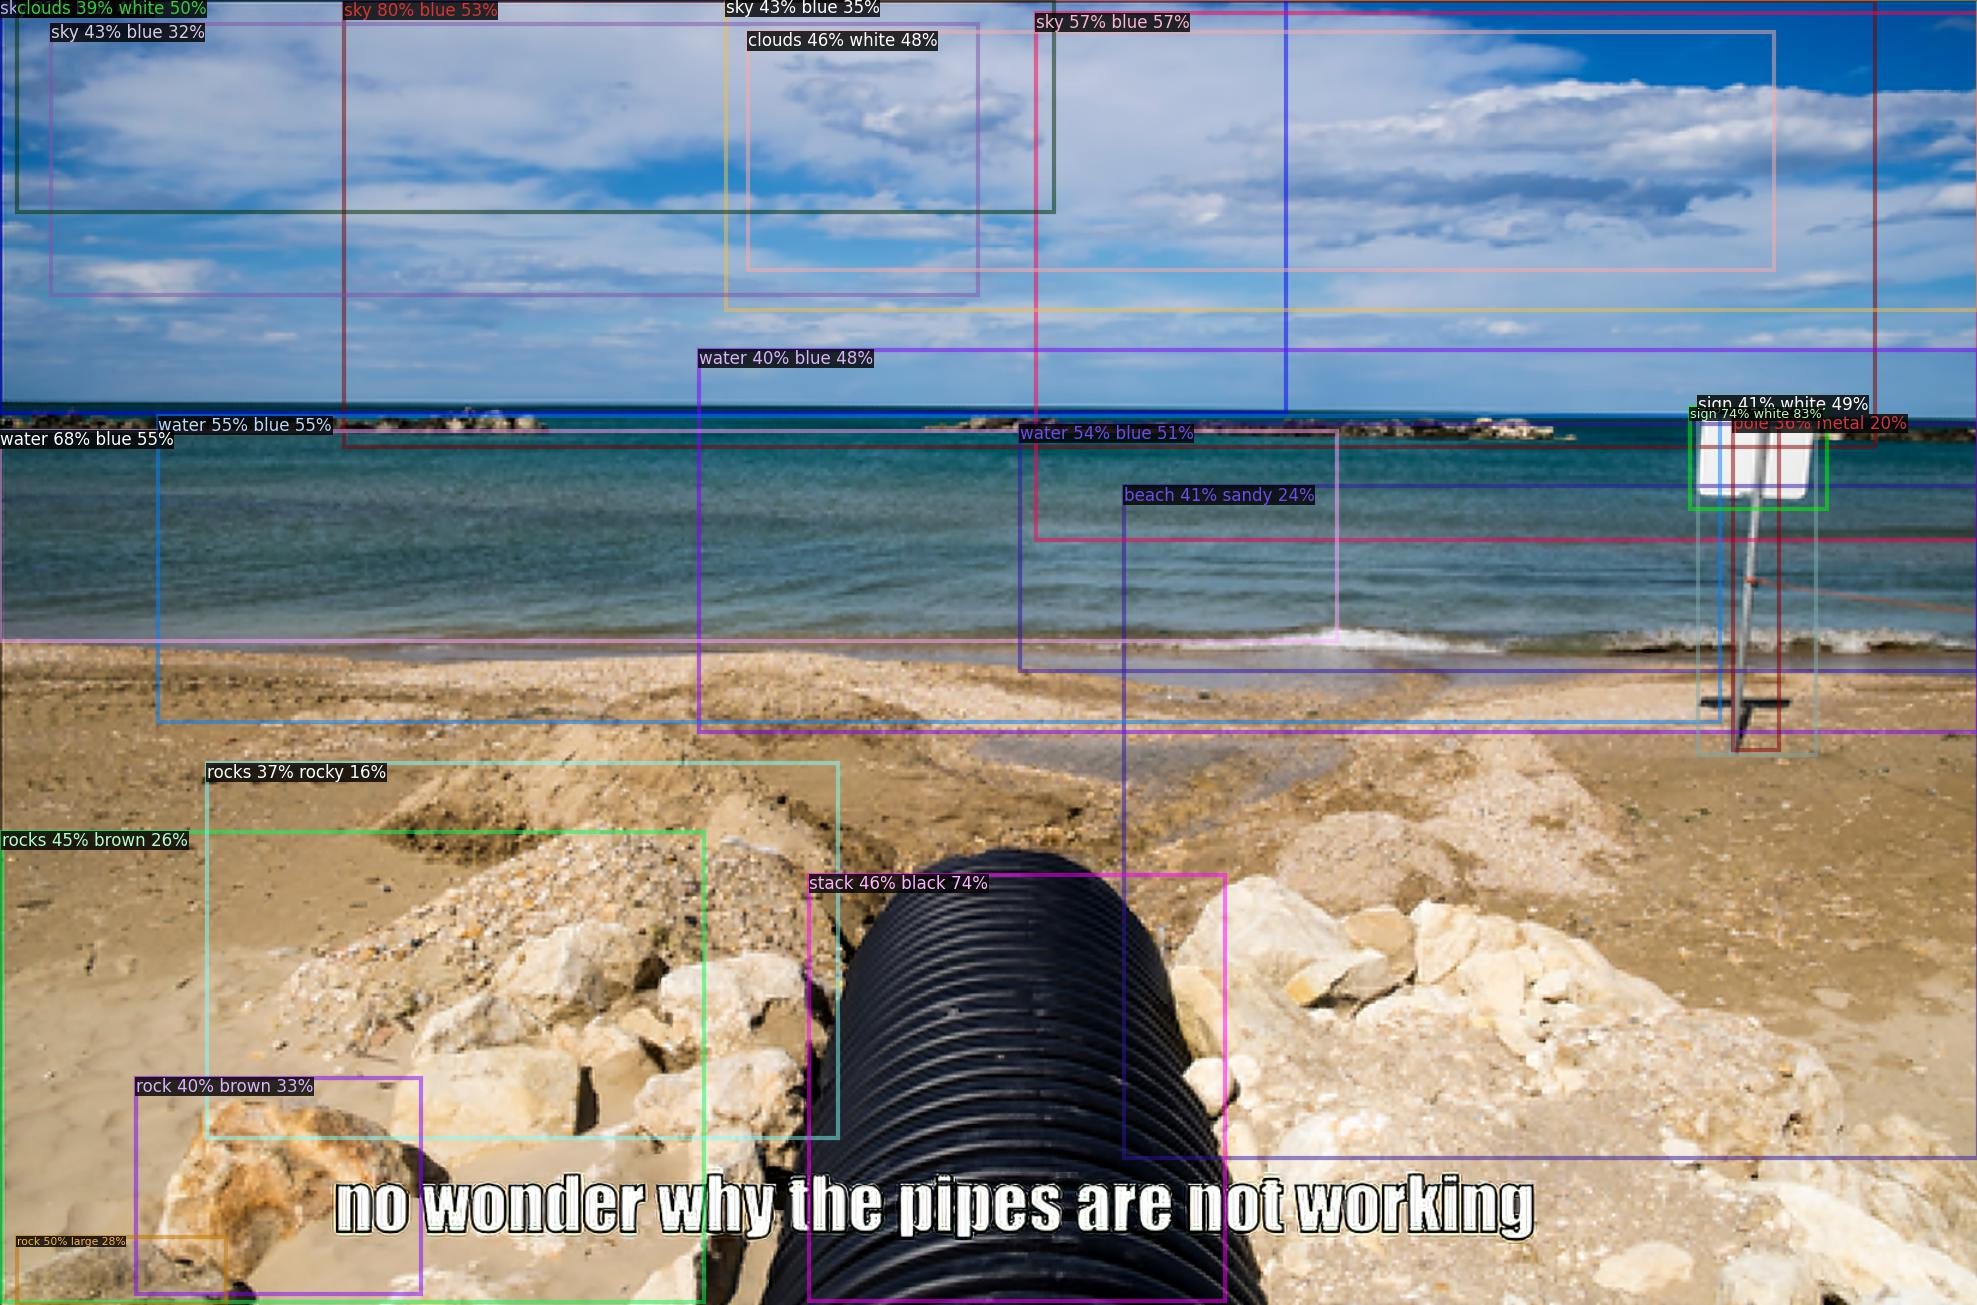

instances:
 Instances(num_instances=20, image_height=1088, image_width=1648, fields=[pred_boxes, scores, pred_classes, attr_scores, attr_classes])

boxes:
 Boxes(tensor([[0.0000e+00, 1.0138e+00, 1.0716e+03, 3.4539e+02],
        [2.8649e+02, 2.4886e+00, 1.5624e+03, 3.7397e+02],
        [1.4084e+03, 3.4067e+02, 1.5224e+03, 4.2514e+02],
        [0.0000e+00, 3.6018e+02, 1.1140e+03, 5.3520e+02],
        [8.6309e+02, 1.2587e+01, 1.6480e+03, 4.5073e+02],
        [1.3203e+02, 3.4820e+02, 1.4335e+03, 6.0250e+02],
        [8.4991e+02, 3.5485e+02, 1.6480e+03, 5.6037e+02],
        [1.4086e+01, 1.0311e+03, 1.8864e+02, 1.0873e+03],
        [6.2306e+02, 2.8016e+01, 1.4786e+03, 2.2629e+02],
        [6.7439e+02, 7.2962e+02, 1.0204e+03, 1.0845e+03],
        [1.7297e+00, 6.9389e+02, 5.8690e+02, 1.0855e+03],
        [6.0483e+02, 4.1359e-01, 1.6480e+03, 2.5935e+02],
        [4.2200e+01, 2.1078e+01, 8.1507e+02, 2.4671e+02],
        [9.3652e+02, 4.0614e+02, 1.6480e+03, 9.6556e+02],
        [1.4146e+03, 3.307

In [6]:

instances, features = doit(im)

# Show the boxes, labels, and features
pred = instances.to('cpu')
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])
print('instances:\n', instances)
print()
print('boxes:\n', instances.pred_boxes)
print()
print('Shape of features:\n', features.shape)

In [7]:
# Verify the correspondence of RoI features
pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(features)
pred_class_probs = torch.nn.functional.softmax(pred_class_logits, -1)[:, :-1]
max_probs, max_classes = pred_class_probs.max(-1)
print("%d objects are different, it is because the classes-aware NMS process" % (NUM_OBJECTS - torch.eq(instances.pred_classes, max_classes).sum().item()))
print("The total difference of score is %0.4f" % (instances.scores - max_probs).abs().sum().item())

0 objects are different, it is because the classes-aware NMS process
The total difference of score is 0.0000
